In [68]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import numpy as np
import tensorflow as tf


# keras module for building LSTM 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout,MaxPooling2D
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku 
from keras.callbacks import EarlyStopping,ModelCheckpoint,LambdaCallback
from keras.optimizers import RMSprop

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.callbacks import LambdaCallback, ModelCheckpoint

Using TensorFlow backend.


In [69]:
df = pd.read_csv("./stockPrice.csv", header=0, na_values='.');
df.head()

,date,open,high,low,close,vol,sma10,sma20,sma50,sma100,vwap,bbmid,bbUpper,bbLower,cci,roc,rsi
0,Mon Apr 06 2009 02:00:00 GMT+0200 (GMT+02:00),168.50,170.50,166.00,167.25,6202062,167.2500,167.2500,167.2500,167.2500,167.916667,167.2500,167.250000,167.250000,0.000000,NaN,58.528428
1,Tue Apr 07 2009 02:00:00 GMT+0200 (GMT+02:00),167.50,169.25,165.25,166.50,7355104,166.8750,166.8750,166.8750,166.8750,167.419352,166.8750,167.625000,166.125000,-66.666667,NaN,57.333669
2,Wed Apr 08 2009 02:00:00 GMT+0200 (GMT+02:00),164.50,169.50,164.25,169.50,5001402,167.7500,167.7500,167.7500,167.7500,167.508459,167.7500,170.299510,165.200490,35.000000,NaN,60.782252
3,Thu Apr 09 2009 02:00:00 GMT+0200 (GMT+02:00),170.00,170.50,168.00,170.50,1924916,168.4375,168.4375,168.4375,168.4375,167.711275,168.4375,171.685095,165.189905,133.333333,NaN,61.888061
4,Tue Apr 14 2009 02:00:00 GMT+0200 (GMT+02:00),172.25,175.75,170.75,173.75,8406764,169.5000,169.5000,169.5000,169.5000,169.371485,169.5000,174.647815,164.352185,148.664344,NaN,65.311415


In [70]:
lol = df.copy()
lol["1pred"] = (df["close"].shift(-1) - df["close"]) / df["close"]
lol["3pred"] = (df["close"].shift(-3) - df["close"]) / df["close"]
lol["5pred"] = (df["close"].shift(-5) - df["close"]) / df["close"]
lol["10pred"] = (df["close"].shift(-10) - df["close"]) / df["close"]

# lol["1predB"] = (df["close"].shift(-1) > df["close"])
# lol["3predB"] = (df["close"].shift(-3) > df["close"])
# lol["5predB"] = (df["close"].shift(-5) > df["close"])
# lol["10predB"] = (df["close"].shift(-10) > df["close"])

lol.loc[df["close"].shift(-1) > df["close"] , '1predB'] = 0
lol.loc[df["close"].shift(-1) < df["close"] , '1predB'] = 1
lol.loc[df["close"].shift(-1) > df["close"] , '3predB'] = 0
lol.loc[df["close"].shift(-1) < df["close"] , '3predB'] = 1
lol.loc[df["close"].shift(-1) > df["close"] , '5predB'] = 0
lol.loc[df["close"].shift(-1) < df["close"] , '5predB'] = 1
lol.loc[df["close"].shift(-1) > df["close"] , '10predB'] = 0
lol.loc[df["close"].shift(-1) < df["close"] , '10predB'] = 1

lol["5max"] = lol["close"].rolling(window=5).max()
lol["10max"] = lol["close"].rolling(window=10).max()
lol["20max"] = lol["close"].rolling(window=20).max()

lol["5low"] = lol["close"].rolling(window=5).min()
lol["10low"] = lol["close"].rolling(window=10).min()
lol["20low"] = lol["close"].rolling(window=20).min()

lol["vol%"] =  (df["vol"] - df["vol"].shift(1)) /df["vol"].shift(1)

lol = lol.dropna()
lol.head()

,date,open,high,low,close,vol,sma10,sma20,sma50,sma100,...,3predB,5predB,10predB,5max,10max,20max,5low,10low,20low,vol%
19,Wed May 06 2009 02:00:00 GMT+0200 (GMT+02:00),182.75,187.75,181.00,186.50,7886450,180.000,174.3625,174.362500,174.362500,...,1.0,1.0,1.0,187.00,187.00,187.00,180.50,171.75,164.5,-0.595854
20,Thu May 07 2009 02:00:00 GMT+0200 (GMT+02:00),187.50,191.00,185.25,185.50,8991542,181.375,175.2750,174.892857,174.892857,...,0.0,0.0,0.0,187.00,187.00,187.00,181.25,174.25,164.5,0.140125
21,Fri May 08 2009 02:00:00 GMT+0200 (GMT+02:00),185.50,190.50,185.50,188.25,7690750,182.775,176.3625,175.500000,175.500000,...,1.0,1.0,1.0,188.25,188.25,188.25,183.00,176.50,164.5,-0.144668
22,Mon May 11 2009 02:00:00 GMT+0200 (GMT+02:00),188.75,189.00,182.75,186.75,7042418,183.650,177.2250,175.989130,175.989130,...,1.0,1.0,1.0,188.25,188.25,188.25,183.00,176.50,164.5,-0.084300
23,Tue May 12 2009 02:00:00 GMT+0200 (GMT+02:00),185.50,188.00,183.75,183.75,6861330,183.900,177.8875,176.312500,176.312500,...,1.0,1.0,1.0,188.25,188.25,188.25,183.75,176.50,164.5,-0.025714


In [86]:
# clear = lol.copy()
dfC = pd.DataFrame()
dfC["vol"] = lol["vol%"]
dfC["sma10"] = lol["sma10"]  / lol["close"]
dfC["sma20"] = lol["sma20"]  / lol["close"]
dfC["sma50"] = lol["sma50"] / lol["close"]
dfC["sma100"] = lol["sma100"] / lol["close"]
dfC["vwap"] = lol["vwap"] / lol["close"]
dfC["bbmid"] = lol["bbmid"] / lol["close"]
dfC["bbUpper"] = lol["bbUpper"] / lol["close"]
dfC["bbLower"] = lol["bbLower"] / lol["close"]
dfC["cci"] = lol["cci"] 
dfC["rsi"] = lol["rsi"]
dfC["5max"] = lol["5max"] / lol["close"]
dfC["10max"] = lol["10max"] / lol["close"]
dfC["20max"] = lol["20max"] / lol["close"]
dfC["5low"] = lol["5low"] / lol["close"]
dfC["10low"] = lol["10low"] / lol["close"]
dfC["20low"] = lol["20low"] / lol["close"]
dfC["1pred"] = lol["1pred"]
dfC["3pred"] = lol["3pred"]
dfC["5pred"] = lol["5pred"]
dfC["10pred"] = lol["10pred"]
dfC["1predB"] = lol["1predB"]
dfC["3predB"] = lol["3predB"]
dfC["5predB"] = lol["5predB"]
dfC["10predB"] = lol["10predB"]

dfC.replace([np.inf, -np.inf], np.nan)
dfC.dropna(inplace=True)
dfC.head()

,vol,sma10,sma20,sma50,sma100,vwap,bbmid,bbUpper,bbLower,cci,...,10low,20low,1pred,3pred,5pred,10pred,1predB,3predB,5predB,10predB
19,-0.595854,0.965147,0.934920,0.934920,0.934920,0.935761,0.934920,1.007645,0.862194,130.777361,...,0.920912,0.882038,-0.005362,0.001340,-0.034853,-0.044236,1.0,1.0,1.0,1.0
20,0.140125,0.977763,0.944879,0.942819,0.942819,0.944775,0.944879,1.020220,0.869538,133.510756,...,0.939353,0.886792,0.014825,-0.009434,-0.024259,-0.052561,0.0,0.0,0.0,0.0
21,-0.144668,0.970916,0.936853,0.932271,0.932271,0.934186,0.936853,1.013623,0.860082,125.482707,...,0.937583,0.873838,-0.007968,-0.043825,-0.043825,-0.059761,1.0,1.0,1.0,1.0
22,-0.084300,0.983400,0.948996,0.942378,0.942378,0.943973,0.948996,1.028067,0.869925,96.179851,...,0.945114,0.880857,-0.016064,-0.030790,-0.017403,-0.036145,1.0,1.0,1.0,1.0
23,-0.025714,1.000816,0.968095,0.959524,0.959524,0.961258,0.968095,1.048034,0.888156,78.656463,...,0.960544,0.895238,-0.020408,-0.020408,-0.008163,-0.024490,1.0,1.0,1.0,1.0


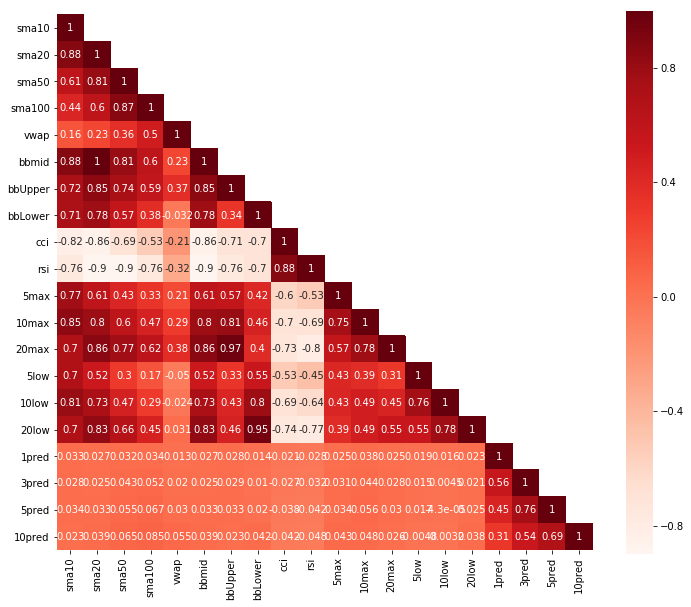

In [87]:
#corelation matrix.
corr= dfC[['sma10', 'sma20', 'sma50', 'sma100', 'vwap', 'bbmid', 'bbUpper', 'bbLower', 'cci', 'rsi', '5max', '10max', '20max', '5low', '10low', '20low', '1pred', '3pred', '5pred', '10pred']].corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(12,10)
sns.heatmap(data=corr,mask=mask,square=True,annot=True,cbar=True,cmap=plt.cm.Reds)

dfC.to_csv('./foo')

In [92]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

# def scale_data(df):
#     min_max_scaler = MinMaxScaler()
 
#     for col in df.columns:
#         df[col] = min_max_scaler.fit_transform(df[col].values.reshape(-1, 1))
    
#     return df
 
df_stock = dfC[['sma10', 'sma20', 'sma50', 'sma100', 'vwap', 'bbmid', 'bbUpper', 'bbLower', 'rsi', '5max', '10max', '20max', '5low', '10low', '20low', '1pred']]    
# df_stock_norm = df_stock.copy()
# df_stock= scale_data(df_stock)

dataset = df_stock.values
dataset = dataset.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

print(dataset)


[[0.3482194  0.29788637 0.28880298 ... 0.68810725 0.58396244 0.42028466]
 [0.39311814 0.32167435 0.30605423 ... 0.76083326 0.60073256 0.4884616 ]
 [0.36875105 0.3025036  0.28301847 ... 0.75385284 0.55504394 0.4114827 ]
 ...
 [0.44355965 0.4383552  0.4100281  ... 0.9017508  0.907562   0.39218894]
 [0.4946587  0.4689591  0.44060528 ... 0.95508814 0.9551997  0.4162036 ]
 [0.51881623 0.4814546  0.45551145 ... 0.9808731  0.9782293  0.4830671 ]]


In [101]:
def create_dataset(dataset):
  dataX, dataY = [], []
  for i in range(len(dataset)-1):
    dataX.append(dataset[i][:-1])
    dataY.append(dataset[i][-1:])
  return np.asarray(dataX), np.asarray(dataY)

print(dataset)
X, Y = create_dataset(dataset)


[[0.3482194  0.29788637 0.28880298 ... 0.68810725 0.58396244 0.42028466]
 [0.39311814 0.32167435 0.30605423 ... 0.76083326 0.60073256 0.4884616 ]
 [0.36875105 0.3025036  0.28301847 ... 0.75385284 0.55504394 0.4114827 ]
 ...
 [0.44355965 0.4383552  0.4100281  ... 0.9017508  0.907562   0.39218894]
 [0.4946587  0.4689591  0.44060528 ... 0.95508814 0.9551997  0.4162036 ]
 [0.51881623 0.4814546  0.45551145 ... 0.9808731  0.9782293  0.4830671 ]]


In [103]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,shuffle=False, random_state=0)

In [112]:
# reshape input to be [samples, time steps, features]

timeSteps = 15; 
x_train = np.reshape(x_train, (x_train.shape[0], timeSteps, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], timeSteps, x_test.shape[1]))

In [115]:
model = Sequential()
model.add(LSTM(10, input_shape=(timeSteps, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(x_train, y_train, epochs=5, batch_size=1, verbose=2)
#save model for later use
model.save('./savedModel')

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
 - 55s - loss: 0.0090
Epoch 2/5
 - 58s - loss: 0.0028
Epoch 3/5
 - 47s - loss: 0.0027
Epoch 4/5
 - 45s - loss: 0.0026
Epoch 5/5
 - 44s - loss: 0.0026


In [120]:
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)

print(trainPredict)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(testPredict)
test_y = scaler.inverse_transform(y_test)
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:,0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

[[0.44293797]
 [0.44680983]
 [0.44448882]
 ...
 [0.44352219]
 [0.45325395]
 [0.4516467 ]]


ValueError: non-broadcastable output operand with shape (1959,1) doesn't match the broadcast shape (1959,16)

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[1:len(trainPredict)+1, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict):len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [74]:
# SEQLEN = 10
# df = df_stock.copy()
# df_input = df.drop(columns="1pred")
# df_target = df["1pred"]

# df_input = df_input.values
# df_target = df_target.values

# # X_train.reshape(-1,1, X_train.shape[1])
    
# X = np.reshape(df_input, (-1, SEQLEN, len(df_input[0])))
# Y = np.reshape(df_target, (-1, SEQLEN, 1))

In [75]:
# x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [83]:
model = Sequential()
model.add(LSTM(171, input_shape=(10, 15)))
# model.add(Dense(len(chars), activation='tanh'))
# model.add(Dense(len(chars), activation='sigmoid'))
# model.add(Dense(len(chars), activation='softmax'))
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [84]:
# fit model using our gpu
with tf.device('/gpu:0'):
    model.fit(x_train, y_train,
              batch_size=128,
              epochs=501,
              verbose=2)

ValueError: Error when checking target: expected lstm_4 to have 2 dimensions, but got array with shape (171, 10, 1)

In [44]:
from keras.models import Sequential
from keras import layers
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

def model(X_train, Y_train, X_val, Y_val):
    
    model = Sequential()
    model.add(Dense({{choice([128, 256, 512, 1024])}}, input_shape=(784,)))
    model.add(Activation({{choice(['relu', 'sigmoid'])}}))
    model.add(Dropout({{uniform(0, 1)}}))
    model.add(Dense({{choice([128, 256, 512, 1024])}}))
    model.add(Activation({{choice(['relu', 'sigmoid'])}}))
    model.add(Dropout({{uniform(0, 1)}}))
    
    if conditional({{choice(['two', 'three'])}}) == 'three':
        model.add(Dense({{choice([128, 256, 512, 1024])}}))
        model.add(Activation({{choice(['relu', 'sigmoid'])}}))
        model.add(Dropout({{uniform(0, 1)}}))
        
    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    adam = keras.optimizers.Adam(lr={{choice([10**-3, 10**-2, 10**-1])}})
    rmsprop = keras.optimizers.RMSprop(lr={{choice([10**-3, 10**-2, 10**-1])}})
    sgd = keras.optimizers.SGD(lr={{choice([10**-3, 10**-2, 10**-1])}})
   
    choiceval = {{choice(['adam', 'sgd', 'rmsprop'])}}
    if choiceval == 'adam':
        optim = adam
    elif choiceval == 'rmsprop':
        optim = rmsprop
    else:
        optim = sgd
        
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=optim)
    model.fit(X_train, Y_train,
              batch_size={{choice([128,256,512])}},
              nb_epoch=20,
              verbose=2,
              validation_data=(X_val, Y_val))
    score, acc = model.evaluate(X_val, Y_val, verbose=0)
    print('Test accuracy:', acc)
    
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}

In [46]:
X = dfC[['sma10', 'sma20', 'sma50', 'sma100', 'vwap', 'bbmid', 'bbUpper', 'bbLower', 'cci', 'rsi', '5max', '10max', '20max', '5low', '10low', '20low']]
X = preprocessing.scale(X)
Y = dfC[["1predB", "3predB", "5predB", "10predB"]]


x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

# best_run, best_model = optim.minimize(model=model,
#                                       data=data,
#                                       algo=tpe.suggest,
#                                       max_evals=30,
#                                       trials=Trials(),
#                                       notebook_name='price')

((1715, 16), (735, 16), (1715, 4), (735, 4))

In [ ]:
# from keras.models import Sequential
# from keras import layers
# from hyperopt import Trials, STATUS_OK, tpe
# from hyperas import optim
# from hyperas.distributions import choice, uniform

# input_dim = x_train.shape[1]  # Number of features
# output_dim = y_train.shape[1]  # Number of features

# with tf.device('/gpu:0'):
#     model = Sequential()
#     model.add(layers.Dense(input_dim * 2, input_dim=input_dim, activation='relu'))
#     model.add(layers.Dense(input_dim * 4, activation='relu'))
#     # model.add(layers.Dropout(.8))

#     model.add(layers.Dense(input_dim * 8, activation='relu'))
#     # model.add(layers.Dropout(.8))

#     model.add(layers.Dense(input_dim * 8, activation='relu'))
#     # model.add(layers.Dropout(.8))
#     model.add(layers.Dense(input_dim * 4, activation='relu'))

#     model.add(layers.Dense(input_dim * 4, activation='relu'))

#     model.add(layers.Dense(input_dim * 2, activation='relu'))

#     model.add(layers.Dense(input_dim, activation='relu'))

#     model.add(layers.Dense(output_dim, activation='linear'))




In [ ]:

# model.compile(loss='mean_squared_error', 
#                optimizer='adam', 
#                metrics=['accuracy'])
# model.summary()

In [ ]:
# from keras.callbacks import EarlyStopping
    
# es = EarlyStopping(monitor='val_loss', mode='min', patience=20)

# model_output = model.fit(x_train, y_train,
#                     epochs=1000,
# #                     verbose=10,
#                     validation_data=(x_test, y_test),
#                     batch_size=x_train.shape[1],
# #                     use_multiprocessing=True, 
# #                     workers=8,
#                     callbacks=[es])

In [ ]:
# loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
# print("Training Accuracy: {:.4f}".format(accuracy))
# loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
# print("Testing Accuracy:  {:.4f}".format(accuracy))


# print('Training Accuracy : ' , np.mean(model_output.history["acc"]))
# print('Validation Accuracy : ' , np.mean(model_output.history["val_acc"]))



# # Plot training & validation accuracy values
# plt.plot(model_output.history['acc'])
# plt.plot(model_output.history['val_acc'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

# # Plot training & validation loss values
# plt.plot(model_output.history['loss'])
# plt.plot(model_output.history['val_loss'])
# plt.title('model_output loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

In [ ]:

# X = dfC[['sma10', 'sma20', 'sma50', 'sma100', 'vwap', 'bbmid', 'bbUpper', 'bbLower', 'cci', 'rsi', '5max', '10max', '20max', '5low', '10low', '20low']]
# X = preprocessing.scale(X)
# Y = dfC[["1predB", "3predB", "5predB", "10predB"]]


# x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
# x_train.shape, x_test.shape, y_train.shape, y_test.shape

In [ ]:
# input_dim = x_train.shape[1]  # Number of features
# output_dim = y_train.shape[1]  # Number of features
# print(output_dim)
# with tf.device('/gpu:0'):
#     model = Sequential()
#     model.add(layers.Dense(input_dim * 2, input_dim=input_dim, activation='relu'))
#     model.add(layers.Dense(input_dim * 4, activation='relu'))
#     # model.add(layers.Dropout(.8))

#     model.add(layers.Dense(input_dim * 8, activation='relu'))
#     # model.add(layers.Dropout(.8))

#     model.add(layers.Dense(input_dim * 8, activation='relu'))
#     # model.add(layers.Dropout(.8))
#     model.add(layers.Dense(input_dim * 4, activation='relu'))

#     model.add(layers.Dense(input_dim * 4, activation='relu'))

#     model.add(layers.Dense(input_dim * 2, activation='relu'))

#     model.add(layers.Dense(input_dim, activation='relu'))

#     model.add(layers.Dense(output_dim, activation='softmax'))

In [ ]:
# model.compile(loss='categorical_crossentropy', 
#                optimizer='adam', 
#                metrics=['accuracy'])
# model.summary()

In [ ]:
# from keras.callbacks import EarlyStopping
    
# es2 = EarlyStopping(monitor='val_loss', mode='min', patience=30)

# model_output = model.fit(x_train, y_train,
#                     epochs=100,
# #                     verbose=10,
#                     validation_data=(x_test, y_test),
#                     batch_size=x_train.shape[1])
# #                     use_multiprocessing=True, 
# #                     workers=8,
# #                     callbacks=[es2])

In [ ]:
# from sklearn.metrics import confusion_matrix


# loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
# print("Training Accuracy: {:.4f}".format(accuracy))
# loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
# print("Testing Accuracy:  {:.4f}".format(accuracy))


# print('Training Accuracy : ' , np.mean(model_output.history["acc"]))
# print('Validation Accuracy : ' , np.mean(model_output.history["val_acc"]))

# y_pred = model.predict(x_test)
# y_pred = (y_pred > 0.5) 

# print(confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1)))

    
# # Plot training & validation accuracy values
# plt.plot(model_output.history['acc'])
# plt.plot(model_output.history['val_acc'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

# # Plot training & validation loss values
# plt.plot(model_output.history['loss'])
# plt.plot(model_output.history['val_loss'])
# plt.title('model_output loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()